## Introduction

This notebook illustrates how we can use NER to search for placenames in a corpus, and enhance a gazetteer. It uses two datesets to illustrate the concepts.

1) [Geograph](https://geograph.org.uk) 
This site invites users to take pictures in the UK and add descriptions. It has almost 7 million pictures, and the data are licenced using a CC By-SA licence, making them available for research as long as we keep the names of the users, and allow others to have access to any data we might create.

2) [Ordnance Survey](https://ordnancesurvey.co.uk/) 50k gazetteer
This gazetteer was published under a UK Open Government licence and contains all place name found on 1:50k maps in the UK. It is a legacy product (i.e. not used or updated any more), but it is suitable for our purposes.

We are going to look for names found in the Geograph data that don't exist in the gazetteer. Since we know that many names occur multiple times, we will do this locally, to increase the chances that we really find new names.

**The first block of our code reads in data and builds a simple spatial index for the gazetteer. We only need to do this once.**

In [1]:
import OSGridConverter #To convert from =SGB36 to WGS84
import pandas as pd #To use pandas for elegant data handling
import spacy #Our NLP tools
import matplotlib.pyplot as plt #To plot results


import os #We import os to stop a weird kernel crash...
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

#Load a language model to do NLP
nlp = spacy.load("en_core_web_sm")

In [2]:
#First we read in the geograph data
geograph = pd.read_csv('./data/geograph_mini_corpus.csv')
print(len(geograph))
geograph.head()

138639


,id,author,title,text,lon,lat
0,2749148,M J Richardson,Great Blasket Island - 1960,Looking northeast along the northwestern side ...,-10.534101,52.097794
1,635105,Bob Shires,White Beach Great Blasket,The only beach on Great Blasket as seen from t...,-10.514872,52.107609
2,635109,Bob Shires,Remaining homes on Great Blasket,The remaining few habited homes of the abandon...,-10.511764,52.104260
3,259349,Nigel Cox,Coumeenoole Bay,Viewed looking back from the Dunmore Head head...,-10.463579,52.109322
4,16917,Pam Brophy,Clogher Beach,The exact gpr for this beach is Q3153003375. T...,-10.463338,52.157867


In [3]:
#Read in the Ordnance Survey gazetteer
os_50k = pd.read_csv('./data/50kgaz2012.txt',sep=':', encoding='utf8', header=None)
os_50k.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,TQ6004,1066 Country Walk,TQ60,50,49.0,0,16.7,104500,560500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
1,2,TQ7715,1066 Country Walk,TQ60,50,54.7,0,31.5,115500,577500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
2,3,TQ7610,1066 Country Walk Bexhill Link,TQ60,50,52.0,0,30.5,110500,576500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
3,4,TQ8315,1066 Country Walk Hastings Link,TQ80,50,54.5,0,36.6,115500,583500,E,ES,E Susx,East Sussex,X,20-SEP-2011,I,199,0,0
4,5,NB5464,A' Beirghe,NB46,58,30.0,6,12.9,964500,154500,W,WI,N Eil,Na h-Eileanan an Iar,X,21-JAN-2003,U,8,0,0


258487


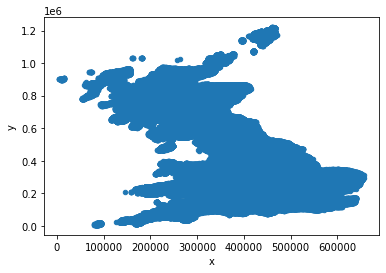

In [4]:
#We need to create locations for each place name in decimal degrees
os_50k[20] = os_50k[4] + os_50k[5]/60
os_50k[21] = os_50k[6] + os_50k[7]/60
os_50k.loc[os_50k[10] == 'W', 21] = -1 * os_50k.loc[os_50k[10] == 'W', 21]

#Tidy up the gazetteer by dropping columns we won't use afterwards
os_trimmed = os_50k.drop([0,1,3,4,5,6,7,10,11,12,14,15,17,18,19], axis = 1)
os_trimmed.head()
os_trimmed.columns = ['name','y','x',
                     'county','type','lat','lon']
os_trimmed.head()

#Plot the gazetteer locations as a sanity check
os_trimmed.plot.scatter(x = 'x', y = 'y')
print(len(os_trimmed))

This block is just to show the NLP results for a single document

In [5]:
#First we demonstrate how the NLP works for a single example document
doc = nlp(geograph.text[11])
spacy.displacy.render(doc, style="ent")
doc_nouns = list(doc.noun_chunks)
print("nouns:",doc_nouns)
for ent in doc.ents:
      print("NER:", ent.text, ent.label_)
          

nouns: [This field, sheep, line, trees, the eastern half, the square, The picture, more or less ENE, The square, a few residences, the minor road, the village, Dun Urlann]
NER: ENE ORG
NER: Dun Urlann ORG


Here we **draw a random sample of documents** from the Geograph data and perform NER on those data. We can rerun this block to build a new sample. The size of this sample can also be changed.

In [6]:
#Now I am going to load a random sample of m Geograph documents and run the NER pipeline
m = 200
sample = geograph.sample(n = m)
docs = list(nlp.pipe(sample.text,n_process=2, batch_size=100))

#Now we store the NER results with the original geograph document ids, text and coordinates
results = list()
for (idxRow, s1), (_, s2) in zip(sample.iterrows(), enumerate(docs)):
    try:
        g = OSGridConverter.latlong2grid (s1.lat, s1.lon, tag = 'WGS84')
        dict = {
            "id": s1.id,
            "x": g.E,
            "y": g.N,
            "entities": s2.ents,
            "text": s1.text   
        }
        results.append(dict)
    except ValueError:
        print("Problem with a document", s1.text)
        #Ignore documents we couldn't parse for some reason

In [7]:
#Show the results - these are essentially all the NER tokens found in each document
for dict in results:
    print(dict.get("id"), dict.get("x"), dict.get("y"), dict.get("entities"))

370194 386629 116910 (West Street, the Gossip Tree)
1792873 421300 269700 (Mousley Hill Farm,)
845495 373720 240820 (Colwall,)
400449 336959 597770 (Wisp Hill,)
1982977 527369 185940 (South Hill Park,)
2268553 258730 330740 (the years, one)
1322341 290329 607380 (Lavern Bridge, the Lowther Hills, Dalveen Pass)
1153122 386139 122620 (St. James Street,)
1670573 548979 157810 (Chevening Church, Ashfield Wood, Minney Wood, Downs, Spinney, Star Hill Wood)
1418993 211650 734600 ()
2875825 188469 705690 (Inverliever Forest,)
862623 448499 489960 (Gallow Hill, Boltby Forest)
1255757 155616 558892 ()
1562296 315420 788330 (Glen Callater, the Callater Burn, Clunie Water)
1093184 408619 210930 ()
2183395 196829 233380 (Cartington Hill, Cnwcymorfol,Farm, second)
2775351 327010 210920 (Blorenge, Foxhunter)
1275578 339930 630540 (the Minchmoor Road, Foulshiels Hill)
1339537 385840 527900 (Noon Hill,)
2810431 294909 565610 ()
540385 120740 932770 (Loch Rog,)
202627 449699 245700 (Thorpe Road,)
155676

We can change the resolution of our local gazetteer and explore how this changes our results.

In [9]:
#We build a simple index using rectangular grid cells
#Each cell contains all placenames from the gazetteer for that cell and can be used to do a lookup
#cellSize determines the resolution in metres

cellSize = 5000
minx = os_trimmed['x'].min()
maxx = os_trimmed['x'].max()
miny = os_trimmed['y'].min()
maxy = os_trimmed['y'].max()

w = maxx - minx
h = maxy - miny

nc = int(w/cellSize) + 1
nr = int(h/cellSize) + 1

gaz = pd.DataFrame(index=range(nc),columns=range(nr))

#Now we populate the index with names
for index, row in os_trimmed.iterrows():
    i = int((row['x'] - minx)/cellSize)
    j = int((row['y'] - minx)/cellSize)
    name = row['name']
    
    if pd.isnull(gaz.at[i,j]):
        gaz.at[i,j] = {name}
    else:
        names = gaz.at[i,j]
        names.add(name)
        gaz.at[i,j] = names

In [10]:
#Example output for a single cell - returns nan if no names present
gaz.at[20,20]

nan

If we change the sample of names, or the resolution of the gazetteer, then the results of the following **comparison** should change.

In [11]:
#Now we are going to compare the gazetteer names with those we found

data = list()
#We iterate through all our results
for dict in results:
    #First we get the cell indices for the gazetteer
    x = dict.get("x")
    y = dict.get("y")
    i = int((x - minx)/cellSize)
    j = int((y - minx)/cellSize)
    try:
        #Now we find the names in that cell - n.B. we ignore for now the fact that Geograph cell could be at a boundary
        gazNames = gaz.at[i,j]
        #Deal with a cell having no values in the gazetteer
        if (isinstance(gazNames,set) == False): 
            #print(type(gazNames))
            gazNames = {"NoNamesFound"}
    except KeyError:
        gazNames = {"NoNamesFound"}
    #Get back the named entities for the text        
    ents = dict.get("entities")
    #Now we iterate through, and find out if each name is already in the local gazetteer
    for ent in ents:        
        if (ent.text in gazNames):
            data.append([dict.get("id"), "Existing", ent.text, ent.label_, x, y]) 
            #print("Found existing name:", ent.text, ent.label_)
        else:
            #print("Potential new name:" , ent.text, ent.label_)
            data.append([dict.get("id"), "New", ent.text, ent.label_, x, y]) 
#Store the results in a dataframe
df = pd.DataFrame(data, columns = ['id', 'status','name','type','x','y'])
df

,id,status,name,type,x,y
0,370194,New,West Street,LOC,386629,116910
1,370194,New,the Gossip Tree,ORG,386629,116910
2,1792873,New,Mousley Hill Farm,ORG,421300,269700
3,845495,Existing,Colwall,ORG,373720,240820
4,400449,Existing,Wisp Hill,GPE,336959,597770
...,...,...,...,...,...,...
318,3156898,New,about 5.25pm,CARDINAL,505299,118470
319,3156898,New,late September,DATE,505299,118470
320,3156898,New,Lower Street,FAC,505299,118470
321,3156898,New,Brooks,ORG,505299,118470


In [12]:
#Split results into existing and candidate names for reporting
new = df.loc[df['status'] == 'New']
existing = df.loc[df['status'] == 'Existing']

Text(0.5, 1.0, 'Counts for existing names')

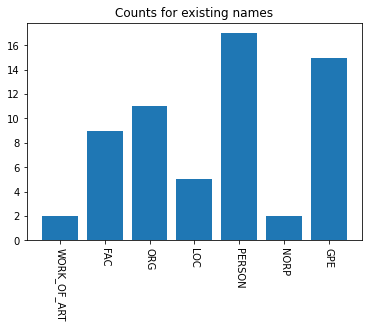

In [13]:
#Create a bar plot of existing names
count = list()
values = list()
for value in set(existing['type']):
    count.append(list(existing['type']).count(value))
    values.append(value)
y_pos = range(len(values))
p = plt.bar(y_pos,count)
# Rotation of the bars names
plt.xticks(y_pos, values, rotation=270)
plt.title('Counts for existing names')

Text(0.5, 1.0, 'Counts for candidate new names')

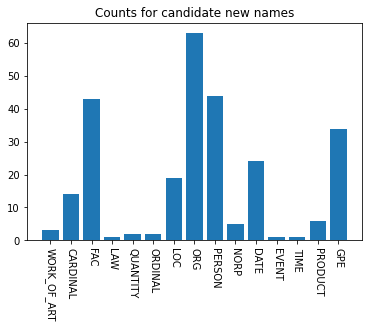

In [14]:
#Create a bar plot of new names
count = list()
values = list()
for value in set(new['type']):
    count.append(list(new['type']).count(value))
    values.append(value)
y_pos = range(len(values))
p = plt.bar(y_pos,count)
# Rotation of the bars names
plt.xticks(y_pos, values, rotation=270)
plt.title('Counts for candidate new names')

In [15]:
#Let's look at one example NER class in the candidate names
names = new.loc[new['type'] == 'PERSON']

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(names)

          id status               name    type       x       y
16   1670573    New            Spinney  PERSON  548979  157810
21   1562296    New      Glen Callater  PERSON  315420  788330
28   2775351    New          Foxhunter  PERSON  327010  210920
30   1275578    New    Foulshiels Hill  PERSON  339930  630540
32    540385    New           Loch Rog  PERSON  120740  932770
38   1647785    New              Bonny  PERSON  529780  114790
41    440906    New             Badger  PERSON  400659  248670
42    440906    New               Hill  PERSON  400659  248670
45   1538906    New             Arthur  PERSON  348220  699030
50   1647215    New       Killyclogher  PERSON   59720  536477
53   1384119    New         Beddgelert  PERSON  260900  348500
55    816483    New           Amberley  PERSON  501330  109970
76    772893    New    St Peter's Hill  PERSON  606480  299640
77    772893    New       Deopham Road  PERSON  606480  299640
83    313361    New               Ouse  PERSON  541999 

In [ ]:
cn = len(set(new['name']))
ce = len(set(existing['name']))
print("Found", ce, "unique existing names and", cn, "unique new names.")

In [ ]:
#output all dependencies so that we can reproduce the notebook (we only need this to set things up for Binder)
#%load_ext watermark
#%watermark --iversions